# Bidirectional LSTM with Log_normal series

C:\Users\sushanth\anaconda3\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 0.6399 - val_loss: 0.9016
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1086 - val_loss: 0.8461
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0982 - val_loss: 0.8529
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0828 - val_loss: 0.8097
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0849 - val_loss: 0.7323
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0796 - val_loss: 0.6624
Epoch 7/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0928 - val_loss: 0.5171
Epoch 8/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0827 - val_loss: 0.4461
Epoch 9/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0895 - val_loss: 0.2486
Epoch 10/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0703 - val_loss: 0.0654
Epoch 11/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0766 - val_loss: 0.1136
Epoch 12/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/ste

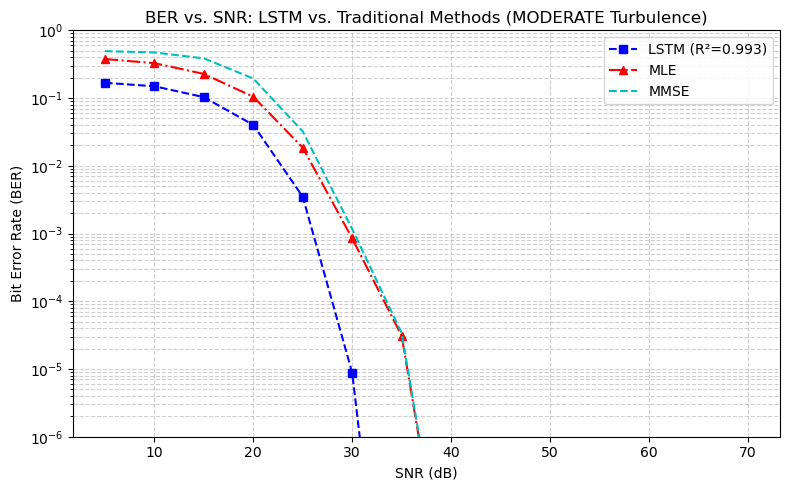

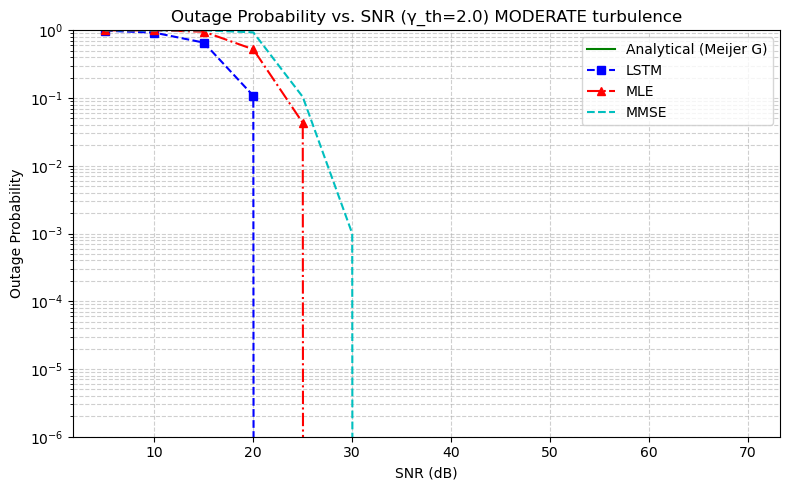

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.special import erfc
from mpmath import mp, meijerg, gamma as gamma_func
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization

# === Parameters 

num_samples = 3000
seq_len = 10
Pt = 10.0
wavelength_nm = 1550
z_km = 1.0
gamma_th = 2.0  # Outage threshold in linear scale

# === Impairment Models ===
def log_normal_weak_turbulence_series(size, sigma=0.3, rho=0.9):
    log_h = np.zeros(size)
    log_h[0] = np.random.normal(0, sigma)
    for i in range(1, size):
        log_h[i] = rho * log_h[i-1] + np.sqrt(1 - rho**2) * np.random.normal(0, sigma)
    return np.exp(log_h)

def pointing_error(jitter_std, size, w_eq=0.01):
    r = np.random.normal(0, jitter_std, size)
    return np.exp(-(r / w_eq) ** 2)

def atmospheric_loss_kim(V_km, wavelength_nm=1550, z_km=1.0):
    if V_km > 50:
        q = 1.6
    elif V_km > 6:
        q = 1.3
    elif V_km > 1:
        q = 0.16 * V_km + 0.34
    else:
        q = 0.5
    gamma = (3.91 / V_km) * (wavelength_nm / 550) ** (-q)
    return np.exp(-gamma * z_km)

# === Dataset Generation ===
a, b = 4 , 1.9 # Weak turbulence parameters
X_seq, y_seq = [], []

for _ in range(num_samples):
    x_bits = np.random.choice([-1, 1], size=seq_len)
    snr_db = np.random.uniform(20, 50)
    snr_linear = 10 ** (snr_db / 10)
    visibility = np.random.uniform(1, 10)
    time_steps = 10
    h_turb_series = log_normal_weak_turbulence_series(time_steps)
    h_point_series = pointing_error(0.002, time_steps)
    h_atm_series = atmospheric_loss_kim(visibility, wavelength_nm, z_km) * np.ones(time_steps)
    h_true_seq = h_turb_series * h_point_series * h_atm_series

    noise = np.random.normal(0, np.sqrt(1 / snr_linear), size=seq_len)
    received = x_bits * h_true_seq + noise

    X_seq.append(received.reshape(-1, 1))
    y_seq.append(np.mean(h_true_seq))

X_seq = np.array(X_seq)
y_seq = np.array(y_seq).reshape(-1, 1)

# === Normalize Inputs ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_flat = X_seq.reshape(-1, seq_len)
X_scaled = scaler_X.fit_transform(X_flat).reshape(-1, seq_len, 1)
y_scaled = scaler_y.fit_transform(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# === LSTM Model ===
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(64)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# === Evaluation Metrics ===
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\n📈 LSTM Results:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# === BER and Outage Probability Evaluation ===
snr_dB_range = np.arange(5, 71, 5)
ber_dl, ber_true, ber_mle, ber_threshold, ber_blind, ber_mmse = [], [], [], [], [], []
outage_true_list, outage_dl_list, outage_mle_list, outage_mmse_list, outage_blind_list = [], [], [], [], []

num_test = 1000
visibility_fixed = np.random.uniform(1, 10)
jitter_std_fixed = 0.002

np.random.seed(42)
h_true_test = []
for _ in range(num_test):
    h_turb_series = log_normal_weak_turbulence_series(time_steps)
    h_point_series = pointing_error(0.002, time_steps)
    h_atm_series = atmospheric_loss_kim(visibility, wavelength_nm, z_km) * np.ones(time_steps)
    h_true_test.append(h_turb_series * h_point_series * h_atm_series)
h_true_test = np.array(h_true_test)

x_seq_test = np.random.choice([-1, 1], size=(num_test, seq_len))

for snr_db in snr_dB_range:
    snr_linear = 10 ** (snr_db / 10)
    noise_std = np.sqrt(1 / snr_linear)

    noise = np.random.normal(0, noise_std, size=(num_test, seq_len))
    received = x_seq_test * h_true_test + noise  # Y=X(H)+N

    # DL Estimation
    received_flat = received.reshape(-1, seq_len)
    received_scaled = scaler_X.transform(received_flat).reshape(-1, seq_len, 1)
    y_pred_scaled = model.predict(received_scaled, verbose=0)
    h_dl = scaler_y.inverse_transform(y_pred_scaled).flatten()
    h_dl_sq = np.clip(h_dl ** 2, 1e-10, None)

    # MLE Estimation
    h_mle = np.mean(received / x_seq_test, axis=1)
    h_mle_sq = np.clip(h_mle ** 2, 1e-10, None)

    # Blind Estimation
    h_blind = np.mean(np.abs(received), axis=1)
    h_blind_sq = np.clip(h_blind ** 2, 1e-10, None)

    # MMSE Estimation
    sigma_h_sq = np.var(h_true_test)
    sigma_n_sq = noise_std ** 2
    norm_x_sq = np.sum(x_seq_test ** 2, axis=1, keepdims=True)
    numerator = np.sum(x_seq_test * received, axis=1, keepdims=True)
    h_mmse = (sigma_h_sq / (sigma_h_sq + sigma_n_sq / norm_x_sq)) * (numerator / norm_x_sq)
    h_mmse_sq = np.clip(h_mmse.flatten() ** 2, 1e-10, None)

    # BER Calculations
    gamma_true = h_true_test ** 2 * snr_linear
    gamma_dl = h_dl_sq[:, np.newaxis] * snr_linear
    gamma_mle = h_mle_sq[:, np.newaxis] * snr_linear
    gamma_mmse = h_mmse_sq[:, np.newaxis] * snr_linear
    gamma_blind = h_blind_sq[:, np.newaxis] * snr_linear

    ber_true_snr = np.mean(0.5 * erfc(np.sqrt(gamma_true / 2)))
    ber_dl_snr = np.mean(0.5 * erfc(np.sqrt(gamma_dl / 2)))
    ber_mle_snr = np.mean(0.5 * erfc(np.sqrt(gamma_mle / 2)))
    ber_mmse_snr = np.mean(0.5 * erfc(np.sqrt(gamma_mmse / 2)))
    ber_blind_snr = np.mean(0.5 * erfc(np.sqrt(gamma_blind / 2)))

    detected = np.sign(received)
    ber_threshold_snr = np.mean(detected != x_seq_test)

    # Outage Probability Calculations
    outage_true_list.append(np.mean(gamma_true < gamma_th))
    outage_dl_list.append(np.mean(gamma_dl < gamma_th))
    outage_mle_list.append(np.mean(gamma_mle < gamma_th))
    outage_mmse_list.append(np.mean(gamma_mmse < gamma_th))
    outage_blind_list.append(np.mean(gamma_blind < gamma_th))

    # Store BER results
    ber_true.append(ber_true_snr)
    ber_dl.append(ber_dl_snr)
    ber_mle.append(ber_mle_snr)
    ber_mmse.append(ber_mmse_snr)
    ber_blind.append(ber_blind_snr)
    ber_threshold.append(ber_threshold_snr)

# === Meijer G-function Based Outage Probability ===
mp.dps = 50  # Set high precision

def outage_prob_meijerG(avg_snr_linear, gamma_th=gamma_th):
    z = a * b * np.sqrt(gamma_th / avg_snr_linear)
    z = max(1e-5, z)  # Avoid instability for small z
    try:
        G = meijerg([[1], []], [[a, b, 0], []], z)
        return float(G / (gamma_func(a) * gamma_func(b)))
    except Exception as e:
        print(f"MeijerG Error for z={z}: {e}")
        return np.nan

analytic_outage = [outage_prob_meijerG(10 ** (snr_db / 10)) for snr_db in snr_dB_range]

# === Plotting ===
plt.figure(figsize=(8, 5))
plt.semilogy(snr_dB_range, ber_dl, 'bs--', label=f'LSTM (R²={r2:.3f})')
plt.semilogy(snr_dB_range, ber_mle, 'r^-.', label="MLE")
plt.semilogy(snr_dB_range, ber_mmse, 'c--', label="MMSE")

#plt.semilogy(snr_dB_range, ber_threshold, 'k:', label="Threshold")
#plt.semilogy(snr_dB_range, ber_blind, 'm-.', label="Blind")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("BER vs. SNR: LSTM vs. Traditional Methods (MODERATE Turbulence)")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.ylim(1e-6, 1)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.semilogy(snr_dB_range, analytic_outage, 'g-', label='Analytical (Meijer G)')
#plt.semilogy(snr_dB_range, outage_true_list, 'm--', label='True Channel')
plt.semilogy(snr_dB_range, outage_dl_list, 'bs--', label='LSTM')
plt.semilogy(snr_dB_range, outage_mle_list, 'r^-.', label='MLE')
plt.semilogy(snr_dB_range, outage_mmse_list, 'c--', label='MMSE')
#plt.semilogy(snr_dB_range, outage_blind_list, 'm-.', label='Blind')
plt.xlabel('SNR (dB)')
plt.ylabel('Outage Probability')
plt.title(f'Outage Probability vs. SNR (γ_th={gamma_th}) MODERATE turbulence')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.ylim(1e-6, 1)
plt.legend()
plt.tight_layout()
plt.show()